# Importação de bibliotecas

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.api.datasets import cifar10
from keras.api.models import Sequential
from keras.api.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.api.utils import to_categorical

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow._api.v2.image import rgb_to_grayscale

from sklearn.model_selection import StratifiedKFold

from typing import ByteString
from enum import Enum

# Importação do dataset

In [2]:
def decode_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file, encoding='bytes')

In [3]:
datasets_dir_path = os.path.join(os.getcwd(), "datasets", "cifar")

# TODO: Atualizar para pegar o caminho de todos os 5 datasets
dataset_treinamento_1: dict = decode_pickle(os.path.join(datasets_dir_path, 'data_batch_1'))
dataset_treinamento_2: dict = decode_pickle(os.path.join(datasets_dir_path, 'data_batch_2'))
dataset_treinamento_3: dict = decode_pickle(os.path.join(datasets_dir_path, 'data_batch_3'))
dataset_treinamento_4: dict = decode_pickle(os.path.join(datasets_dir_path, 'data_batch_4'))
dataset_treinamento_5: dict = decode_pickle(os.path.join(datasets_dir_path, 'data_batch_5'))

datasets_meta: dict = decode_pickle(os.path.join(datasets_dir_path, 'batches.meta'))
dataset_validacao: dict = decode_pickle(os.path.join(datasets_dir_path, 'test_batch'))

In [4]:
print("Treinamento: ", dataset_treinamento_1.keys())
print("Validacao: ", dataset_validacao.keys())
print("Meta: ", datasets_meta.keys())

Treinamento:  dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Validacao:  dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Meta:  dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])


In [5]:
CIFAR_BATCH_LABEL = b'batch_label'
CIFAR_LABELS = b'labels'
CIFAR_DATA = b'data'
CIFAR_FILENAMES = b'filenames'
CIFAR_DATASET_SHAPE = (10000, 3, 32, 32)

CIFAR_META_LABEL_NAME= b'label_names'
CIFAR_META_NUM_CASES_PER_BATCH= b'num_cases_per_batch'
CIFAR_META_NUM_VIS= b'num_vis'

In [6]:
def get_label_name(label_index: np.int8) -> str:
    return datasets_meta[CIFAR_META_LABEL_NAME][label_index].decode('utf-8')

## Tratando os dados

In [7]:
entrada_teste = np.array(dataset_validacao[CIFAR_DATA]).reshape(CIFAR_DATASET_SHAPE)
saida_teste = np.array(dataset_validacao[CIFAR_LABELS])

In [8]:
entradas_1 = np.array(dataset_treinamento_1[CIFAR_DATA]).reshape(CIFAR_DATASET_SHAPE)
saida_1 = np.array(dataset_treinamento_1[CIFAR_LABELS])
nomes_1 = np.array(dataset_treinamento_1[CIFAR_FILENAMES])

entradas_2 = np.array(dataset_treinamento_2[CIFAR_DATA]).reshape(CIFAR_DATASET_SHAPE)
saida_2 = np.array(dataset_treinamento_2[CIFAR_LABELS])
nomes_2 = np.array(dataset_treinamento_2[CIFAR_FILENAMES])

entradas_3 = np.array(dataset_treinamento_3[CIFAR_DATA]).reshape(CIFAR_DATASET_SHAPE)
saida_3 = np.array(dataset_treinamento_3[CIFAR_LABELS])
nomes_3 = np.array(dataset_treinamento_3[CIFAR_FILENAMES])

entradas_4 = np.array(dataset_treinamento_4[CIFAR_DATA]).reshape(CIFAR_DATASET_SHAPE)
saida_4 = np.array(dataset_treinamento_4[CIFAR_LABELS])
nomes_4 = np.array(dataset_treinamento_4[CIFAR_FILENAMES])

entradas_5 = np.array(dataset_treinamento_5[CIFAR_DATA]).reshape(CIFAR_DATASET_SHAPE)
saida_5 = np.array(dataset_treinamento_5[CIFAR_LABELS])
nomes_5 = np.array(dataset_treinamento_5[CIFAR_FILENAMES])

entradas = np.append(entradas_1, entradas_2, axis=0)
entradas = np.append(entradas, entradas_3, axis=0)
entradas = np.append(entradas, entradas_4, axis=0)
entradas = np.append(entradas, entradas_5, axis=0)
print(entradas.shape)

saida = np.append(saida_1, saida_2, axis=0)
saida = np.append(saida, saida_3, axis=0)
saida = np.append(saida, saida_4, axis=0)
saida = np.append(saida, saida_5, axis=0)
print(saida.shape)

nomes = np.append(nomes_1, nomes_2, axis=0)
nomes = np.append(nomes, nomes_3, axis=0)
nomes = np.append(nomes, nomes_4, axis=0)
nomes = np.append(nomes, nomes_5, axis=0)
print(nomes.shape)

(50000, 3, 32, 32)
(50000,)
(50000,)


In [9]:
# Transformando para escala cinza
entradas = entradas.astype('float32')
entradas_transpose = np.transpose(entradas, [0, 2, 3, 1])
entradas_gray = rgb_to_grayscale(
    entradas_transpose
).numpy()
entradas_gray /= 255

entrada_teste = entrada_teste.astype('float32')
entrada_teste_transpose = np.transpose(entrada_teste, [0, 2, 3, 1])
entrada_teste_gray = rgb_to_grayscale(
    entrada_teste_transpose
).numpy()
entrada_teste_gray /= 255

print("Treinamento: ", entradas_gray.shape)
print("Teste: ", entrada_teste_gray.shape)


Treinamento:  (50000, 32, 32, 1)
Teste:  (10000, 32, 32, 1)


## Visualizando alguns itens do dataset

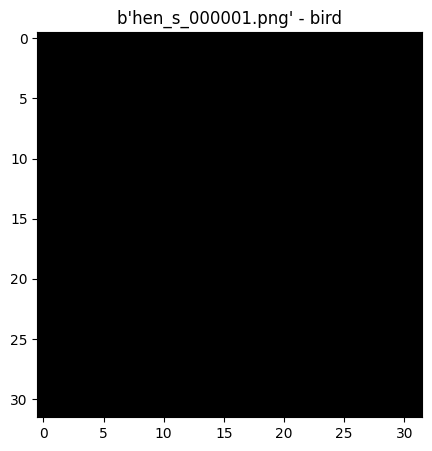

In [10]:
image_index = np.random.randint(0, len(nomes))
image_title = nomes[image_index]
image_data = entradas_gray[image_index]
image_label = saida[image_index]

fig, ax = plt.subplots(figsize=(9,5), nrows=1, ncols=1)
ax.set_title(f"{image_title} - {get_label_name(image_label)}")
ax.imshow(image_data.astype('uint8'), cmap='grey')

plt.show()

In [11]:
# Aplicando OneHotEncoder
saida_encoded = pd.get_dummies(saida)
saida_teste_encoded = pd.get_dummies(saida)

# Criando a Rede Neural Convolucional

In [16]:
# Estrutura da rede
## 1. Convolução
## 2. Pooling (Max Pooling)
## 3. Flattening
## 4. Rede Neural Densa (Classificdor)

def criar_modelo(shape_entrada = (32, 32, 1)):
    sequencial = Sequential(
        name="CIFAR-10",
        layers=[
            Input(
                shape=shape_entrada
            )
        ]
    )

    sequencial.add(
        Conv2D(
            filters=128,
            kernel_size=(3, 3),
            activation='relu'
        )
    )

    sequencial.add(
        BatchNormalization()
    )

    sequencial.add(
        MaxPooling2D(
            pool_size=(2, 2)
        )
    )

    sequencial.add(
        Flatten()
    )

    sequencial.add(
        Dense(
            units=256,
            activation='relu',
        )
    )
    sequencial.add(
        Dropout(rate=0.2)
    )

    sequencial.add(
        Dense(
            units=256,
            activation='relu',
        )
    )
    sequencial.add(
        Dropout(rate=0.2)
    )

    sequencial.add(
        Dense(
            units=10,
            activation='softmax'
        )
    )

    sequencial.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return sequencial
    

In [17]:
modelo = criar_modelo(entradas_gray.shape[1:])

In [18]:
resultado = modelo.fit(
    x=entradas_gray,
    y=saida_encoded,
    batch_size=128,
    epochs=100,
    verbose=1
)

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 102s 258ms/step - accuracy: 0.3744 - loss: 1.9737
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 95s 244ms/step - accuracy: 0.5956 - loss: 1.1536
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 99s 254ms/step - accuracy: 0.6861 - loss: 0.9055
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 101s 257ms/step - accuracy: 0.7480 - loss: 0.7219
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 99s 254ms/step - accuracy: 0.8007 - loss: 0.5704
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 101s 258ms/step - accuracy: 0.8460 - loss: 0.4447
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 100s 256ms/step - accuracy: 0.8787 - loss: 0.3571
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 100s 257ms/step - accuracy: 0.8994 - loss: 0.2985
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 101s 257ms/step - accuracy: 0.9124 - loss: 0.2573
Epoch 10/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 100s 256ms/step - accuracy: 0.9232 - loss: 0.2260
Epoch 11/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 101s 259ms/step - accuracy: 0.9348 - loss: 0.1918
